# Classifying simulated events using a Convolutional Neural Network
We've seen how we can use logistig regression or feed forward neural networks (FFNN) to classify our data,
and now you've also been introduced to what a convolutional neural network is.
In this notebook, we're going to use a convolutional neural network (CNN) to classify our data,
and even combine CNN and FFNN to expand our model.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from helper_functions import normalize_image_data
%load_ext autoreload
%autoreload 2

In [2]:
# Load images and labels.
DATA_PATH = "../data/"

images = np.load(DATA_PATH+"images_training.npy")
labels = np.load(DATA_PATH+"labels_training.npy")

# Introduction
The motivation for uing a CNN to classify this data comes from their huge success in image classification
tasks in recent years. Since we can very easily (and even preferably) represent our data as images, it
is a natural choice to try a model of this type.
This notebook will be a bit more hands-on than the previous ones.

You may recall from the lectures that one of the properties of CNNs is that they use 'filters'/'kernels' to
extract 'features' from images. But how can we know what type of filters to apply? The answer is - we don't need to! Similar to how a FFNN adjusts its weights in order to increase performance, a CNN adjusts its filters and in that way 'learns' the best filters for a given task.

Some very useful documentation to keep at hand while working through this notebook:
* [tensorflow.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers)
* [Scikit-Learn model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html)


## Data preparation
Recall that when we saved our training samples in the import and exploration notebook,
we saved the images as an array with the following dimensions (samples, x_pixels, y_pixels).
This isn't necessarily a format the convolutional layer will accept, because by default image data
has one more dimension - "channels". A single image would have the dimensions (x_pixels, y_pixels, channels).
For a regular RGB picture this is (x_pixels, y_pixels, 3), since you have one channel for each color.
Our data only has one channel, which in a world of colours would be called "grayscale".

The convolutional layer we will use in our model is called Conv2D ([Doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)). Take a look at the documentation to determine if you need to modify the image array in order to input it to the layer.

Recall that you can use [np.reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) to modify your array should you need to.

In [3]:
# Reshape the image array here, if you need to
images = np.reshape(images, (images.shape[0], 16, 16, 1))


One thing that can be useful to check is if we actually saved a balanced dataset. The data is shuffled
when scikit-learn's train_test_split function splits it, so it's not guaranteed. Remember that if you
don't have a balanced dataset, you need to account for this when concidering which metrics to use
in evaluating your model.

Numpy's [np.unique](https://numpy.org/doc/1.18/reference/generated/numpy.unique.html?) works great for this.

In [4]:
# Count how many there are of each class and print the results
unique = np.unique(labels, return_counts=True)
print(unique)


(array([0, 1]), array([4051, 3949], dtype=int64))


Lastly, we split the training data into a training set and a validation set, using indices.
Working with only 10000 you can also split the image array itself.
As in the previous notebooks, [Scikit-Learn's train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) will do the job.

In [5]:
# Split the data into training and validation sets
x_train, x_test, y_train, y_test = train_test_split(images, labels)


# Model
Having a common API for machine learning operations between multiple frameworks is great.
It means you don't need to re-learn how to build a model every time you want to try out something new!
Using the [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model, you simply
add each layer in the order you want, and compile it. Tensorflow takes care of everything.

## Build and compile
We're going to start with just one layer. Take another look at the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to see all the configuration options for the Conv2D layer. As a first step we will stick to defining only the necessary arguments to the layer,
leaving the rest as default.

In [6]:
# Initialize the Sequential model, and add one Conv2D layer to it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=3,
        activation='relu',
        input_shape=images.shape[1:] # Shape of a single image
    )
)
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))


# Add an output layer to the model
# Recall the shape of the input to a dense neural network.
# What is the shape of the output from the Conv2D layer?
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


# Once the model is defined, we need to compile it. 
# This is where we specify the loss function, optimizer, and metrics if we want.
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 801       
Total params: 10,369
Trainable params: 10,369
Non-trainable params: 0
_________________________________________________________________


## Training
We are ready to train the model. Remember to normalize your inputs if you haven't already done that!
You can specify the validation data using the keyword 'validation_data'. Take a look at the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit) for the fit() function to see how it
expect the validation to be formatted.

In [7]:
# Training parameters
batch_size = 32
epochs = 100

In [8]:
training_output = model.fit(
    x=normalize_image_data(x_train),
    y=y_train,
    validation_data=(normalize_image_data(x_test), y_test),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/100
188/188 [==============================] - 2s 9ms/step - loss: 0.5826 - accuracy: 0.6770 - val_loss: 0.5078 - val_accuracy: 0.7400
Epoch 2/100
188/188 [==============================] - 1s 7ms/step - loss: 0.4735 - accuracy: 0.7665 - val_loss: 0.4428 - val_accuracy: 0.7750
Epoch 3/100
188/188 [==============================] - 2s 8ms/step - loss: 0.4150 - accuracy: 0.8120 - val_loss: 0.3954 - val_accuracy: 0.8465
Epoch 4/100
188/188 [==============================] - 1s 7ms/step - loss: 0.3743 - accuracy: 0.8458 - val_loss: 0.3804 - val_accuracy: 0.8310
Epoch 5/100
188/188 [==============================] - 1s 7ms/step - loss: 0.3489 - accuracy: 0.8688 - val_loss: 0.3302 - val_accuracy: 0.9055
Epoch 6/100
188/188 [==============================] - 1s 7ms/step - loss: 0.3260 - accuracy: 0.8808 - val_loss: 0.3102 - val_accuracy: 0.9015
Epoch 7/100
188/188 [==============================] - 1s 7ms/step - loss: 0.2993 - accuracy: 0.8990 - val_loss: 0.3357 - val_accuracy: 0.8270

Epoch 58/100
188/188 [==============================] - 1s 7ms/step - loss: 0.1533 - accuracy: 0.9498 - val_loss: 0.1606 - val_accuracy: 0.9545
Epoch 59/100
188/188 [==============================] - 1s 7ms/step - loss: 0.1395 - accuracy: 0.9558 - val_loss: 0.1627 - val_accuracy: 0.9520
Epoch 60/100
188/188 [==============================] - 1s 7ms/step - loss: 0.1438 - accuracy: 0.9537 - val_loss: 0.1961 - val_accuracy: 0.9320
Epoch 61/100
188/188 [==============================] - 1s 7ms/step - loss: 0.1618 - accuracy: 0.9432 - val_loss: 0.1531 - val_accuracy: 0.9500
Epoch 62/100
188/188 [==============================] - 1s 7ms/step - loss: 0.1458 - accuracy: 0.9528 - val_loss: 0.1570 - val_accuracy: 0.9480
Epoch 63/100
188/188 [==============================] - 1s 7ms/step - loss: 0.1348 - accuracy: 0.9572 - val_loss: 0.1565 - val_accuracy: 0.9480
Epoch 64/100
188/188 [==============================] - 1s 7ms/step - loss: 0.1330 - accuracy: 0.9548 - val_loss: 0.1449 - val_accuracy:

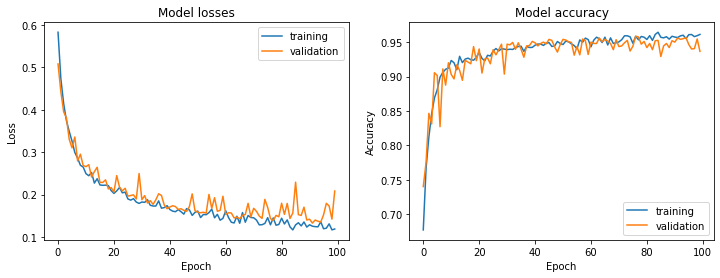

In [9]:
# Side by side plots of losses and accuracies
history = training_output.history
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history['loss'], label='training')
ax[0].plot(history['val_loss'], label='validation')
ax[0].set_title("Model losses")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history['accuracy'], label='training')
ax[1].plot(history['val_accuracy'], label='validation')
ax[1].set_title("Model accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

## Expand and improve the model
Just like with a feed forward neural network, the architecture is just one of the properties
we can tune to improve performance. If you look closer at the model.summary() printout, you can
see that the output after the Conv2D layer has changed shape. It's no longer the same size as our
original image. Why is this?

In the introduction we mentioned that the filters/kernels in a CNN
extract features in the images. One thing we could do, then, is to input those features to an FFNN. Just
like in the dense_neural_network notebook.

In a way we've already done this, except the dense part of our model has only one node, the output node.
Try to add another dense layer before the output. Perhaps you have a dense model from the previous notebook
you can weave in here?

Of course, you can also add another Conv2D layer instead, or increase the number of filters.
In between convolutional layers you can add MaxPool2D layers, and eventually you may start looking at
regularizations like Dropout if necessary.

In [10]:
# Initialize the Sequential model, and add one Conv2D layer to it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=3,
        activation='relu',
        input_shape=images.shape[1:] # Shape of a single image
    )
)
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))


# Add an output layer to the model
# Recall the shape of the input to a dense neural network.
# What is the shape of the output from the Conv2D layer?
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


# Once the model is defined, we need to compile it. 
# This is where we specify the loss function, optimizer, and metrics if we want.
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               102528    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 112,225
Trainable params: 112,225
Non-trainable params: 0
________________________________________________